In [8]:
from keras.datasets import cifar100    
from models.utils import ResNet18, split_dataframe, detect_drifts
import keras
import numpy as np
import models.unmasking_drift_detector as unm
import models.d3_drift_detector as d3
import matplotlib.pyplot as plt

In [5]:
(images_train, labels_train), (images_test, labels_test) = cifar100.load_data()

# svhn_data = loadmat('/home/edstan/Desktop/master_AI/practice/driftDatasets/realWorld/train_32x32.mat')
# svhn_images, svhn_labels = svhn_data['X'], svhn_data['y']
# svhn_images = np.moveaxis(svhn_images, -1, 0)
# cap = svhn_images.shape[0] // 2
# idx = int(0.8 * cap)

In [9]:
images_test.shape, np.unique(labels_test)

((10000, 32, 32, 3),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]))

In [26]:
train_indices = np.where(np.isin(labels_train, range(50)))[0]
X_train = images_train[train_indices]
y_train = labels_train[train_indices]
test_indices = np.where(np.isin(labels_test, range(50)))[0]
X_test = images_test[test_indices]
y_test = labels_test[test_indices]

In [27]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25000, 32, 32, 3), (25000, 1), (5000, 32, 32, 3), (5000, 1))

In [29]:
model = ResNet18(input_shape=(32, 32, 3), n_classes=50)
model.compile(optimizer=keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))
# Epoch 10/10
# 391/391 [==============================] - 367s 939ms/step - loss: 0.6006 - accuracy: 0.8112 - val_loss: 2.5678 - val_accuracy: 0.4432

Epoch 1/10
391/391 [==============================] - 415s 1s/step - loss: 3.1916 - accuracy: 0.1951 - val_loss: 6.9441 - val_accuracy: 0.1288
Epoch 2/10
391/391 [==============================] - 364s 931ms/step - loss: 2.5262 - accuracy: 0.3278 - val_loss: 4.7119 - val_accuracy: 0.1606
Epoch 3/10
391/391 [==============================] - 370s 946ms/step - loss: 2.1502 - accuracy: 0.4135 - val_loss: 2.8707 - val_accuracy: 0.2806
Epoch 4/10
391/391 [==============================] - 369s 943ms/step - loss: 1.8496 - accuracy: 0.4831 - val_loss: 2.7438 - val_accuracy: 0.3204
Epoch 5/10
391/391 [==============================] - 371s 949ms/step - loss: 1.6150 - accuracy: 0.5366 - val_loss: 2.3397 - val_accuracy: 0.3992
Epoch 6/10
391/391 [==============================] - 367s 939ms/step - loss: 1.4014 - accuracy: 0.5919 - val_loss: 2.3641 - val_accuracy: 0.3968
Epoch 7/10
391/391 [==============================] - 361s 924ms/step - loss: 1.1899 - accuracy: 0.6506 - val_loss: 2.0069 - va

In [30]:
extract_features_model = keras.Model(inputs=model.input, outputs=model.get_layer('avg_pool').output)

In [32]:
unseen_data_indices = np.where(np.isin(labels_train, range(50, 100)))[0]
unseen_data = images_train[unseen_data_indices]
unseen_data.shape

(25000, 32, 32, 3)

In [59]:
drifted_data = np.empty((0, 32, 32, 3))
i = 0
last_index = 0
current_index = 0
ground_truth_drifts = []

dimension_limit = 0.9 * images_train.shape[0]
while drifted_data.shape[0] < dimension_limit:
    if i % 2 == 0:
        current_index += np.random.choice([400, 800, 1200, 1600])
        if i != 0:
            ground_truth_drifts.append(drifted_data.shape[0])
        known_batch = X_train[last_index:current_index]
        drifted_data = np.concatenate((drifted_data, known_batch), axis=0)
    else:
        # ground_truth_drifts.append(drifted_data.shape[0])
        batch = unseen_data[last_index:current_index]
        np.random.shuffle(batch)
        drifted_data = np.concatenate((drifted_data, batch), axis=0)
        last_index = current_index
    i += 1

In [60]:
drifted_data.shape

(45600, 32, 32, 3)

In [61]:
features = extract_features_model.predict(drifted_data)
features.shape

1425/1425 [==============================] - 18s 12ms/step


(45600, 512)

In [62]:
batch_size = 400
data_splitted = split_dataframe(features, batch_size)
ground_truth_drifts_batch = np.array(ground_truth_drifts) / 400
ground_truth_drifts_batch = ground_truth_drifts_batch.astype(int)
ground_truth_drifts_batch

array([  4,  12,  16,  18,  22,  26,  30,  32,  36,  38,  42,  46,  54,
        58,  62,  70,  74,  82,  90,  94,  98, 106, 110])

In [63]:
np.save("ground_truth_drifts_batch_cifar.npy", ground_truth_drifts_batch)
np.save("features_cifar.npy", features)

D3:
0.0
Unmasking:
Threshold = 0.56
Change detected at index 2
Change detected at index 67
Change detected at index 78
0.0


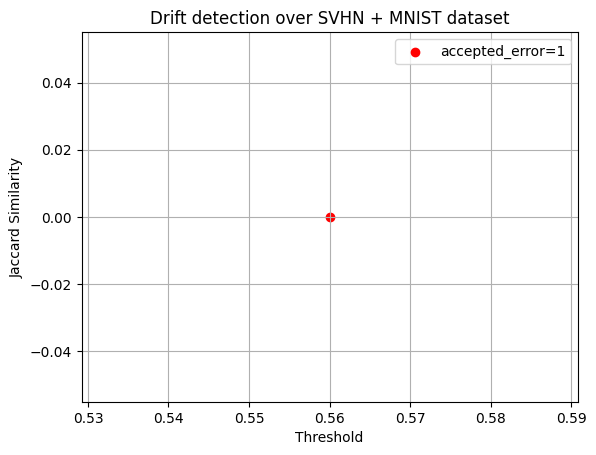

In [64]:
thresholds = [0.56]
jaccard_sim_unm = []

print("D3:")
sim_d3 = detect_drifts(data_splitted, d3.drift_detector, ground_truth_drifts_batch, accepted_error=1, show_drifts=True)
print(sim_d3)

print("Unmasking:")
for thr in thresholds:
    print(f"Threshold = {thr}")
    sim_unm = detect_drifts(data_splitted, unm.drift_detector, ground_truth_drifts_batch, show_drifts=True, accepted_error=1, threshold=thr, min_feature_percentage_remaining=0.05)
    print(sim_unm)
    jaccard_sim_unm.append(sim_unm)




plt.xlabel('Threshold')
plt.ylabel('Jaccard Similarity')
plt.title('Drift detection over SVHN + MNIST dataset')

plt.scatter(thresholds, jaccard_sim_unm, marker='o', color='red', label='accepted_error=1')
# plt.plot(percentages, [sim_d3]*len(percentages), c='blue', label='d3')
plt.grid()
plt.legend()
plt.savefig('/home/edstan/Desktop/master_AI/practice/images/cifar100_jaccard_thresholds_error1.png')
plt.show()